# **Desarrollo: "Categorias de Noticias"**


# **Importanción de Librerías**

In [6]:
# Instalaciones requeridas
!pip install gensim
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 36.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
opencv-contrib-

# **Carga y Visualización Inicial**

In [7]:
# Importe de Librerías
import re
import nltk
nltk.download('averaged_perceptron_tagger_eng')
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import corpora
from gensim.models import LdaModel, Phrases, CoherenceModel

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [8]:
# Descarga de archivos y preparación inicial
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
stop_words.update(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'it', 'will', 'also'])
lemmatizer = WordNetLemmatizer()

# Carga del Dataset, categorías (Entrenamiento y Test)
categories = ['rec.sport.baseball', 'sci.electronics', 'comp.graphics', 'talk.politics.misc']
train_data = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
test_data = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# **Procesamiento**

In [9]:
# Preprocesamiento con conversión de tags (NLTK -> WordNet)
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Filtrado por Nombres y Adjetivos para mayor precisión del modelo
def preprocess_text_pos(text):
    tokens = []
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    for word, tag in nltk.pos_tag(text.split()):
        if tag.startswith('NN') or tag.startswith('JJ'):
            if len(word) > 3 and word not in stop_words:
                tokens.append(lemmatizer.lemmatize(word, get_wordnet_pos(word)))
    return tokens

processed_train_docs = [preprocess_text_pos(doc) for doc in train_data.data]
processed_test_docs = [preprocess_text_pos(doc) for doc in test_data.data]

# Creación de Bigramas y Trigramas
bigram_model = Phrases(processed_train_docs, min_count=5, threshold=100)
trigram_model = Phrases(bigram_model[processed_train_docs], threshold=100)
processed_train_docs = [trigram_model[bigram_model[doc]] for doc in processed_train_docs]
processed_test_docs = [trigram_model[bigram_model[doc]] for doc in processed_test_docs]

In [10]:
# Creación de Diccionario + Corpus
dictionary = corpora.Dictionary(processed_train_docs)
dictionary.filter_extremes(no_below=20, no_above=0.4)

train_corpus = [dictionary.doc2bow(doc) for doc in processed_train_docs]
test_corpus = [dictionary.doc2bow(doc) for doc in processed_test_docs]

# **Entrenamiento y Resultados**

In [11]:
# Entrenamiento del Modelo
lda_model = LdaModel(corpus=train_corpus, id2word=dictionary, num_topics=len(categories),
                     random_state=100, passes=15, alpha=0.1, eta=0.1)

In [12]:
# Impresión de temas descubiertos por el Modelo
print("\n----- Temas Descubiertos por el Modelo -----")
category_map = {v: k for k, v in topic_map.items()}
category_names = train_data.target_names
topics = lda_model.show_topics(formatted=False, num_words=10)
for topic_num, topic_words in topics:
    mapped_category_index = topic_map.get(topic_num, -1)
    category_name = category_names[mapped_category_index] if mapped_category_index != -1 else "Sin asignar"
    words = ", ".join([word for word, prop in topic_words])
    print(f"Tópico #{topic_num+1} (Asignado a: {category_name}):\n  {words}\n")

topic_category_dist = np.zeros((len(categories), len(categories)))
for i, doc_corpus in enumerate(train_corpus):
    doc_topics = lda_model.get_document_topics(doc_corpus, minimum_probability=0.2)
    if doc_topics:
        dominant_topic = max(doc_topics, key=lambda x: x[1])[0]
        true_category_index = train_data.target[i]
        topic_category_dist[dominant_topic, true_category_index] += 1
topic_map = {i: np.argmax(topic_category_dist[i]) for i in range(len(categories))}


----- Temas Descubiertos por el Modelo -----
Tópico #1 (Asignado a: talk.politics.misc):
  people, government, drug, state, system, issue, right, american, many, fact

Tópico #2 (Asignado a: rec.sport.baseball):
  year, game, time, good, president, player, team, last, well, first

Tópico #3 (Asignado a: sci.electronics):
  point, circuit, line, problem, power, voltage, ground, screen, wire, output

Tópico #4 (Asignado a: comp.graphics):
  image, file, system, graphic, program, anyone, data, software, information, computer



----- Precisión del Modelo -----
La precisión (accuracy) del modelo en el conjunto de prueba es: 65.35%



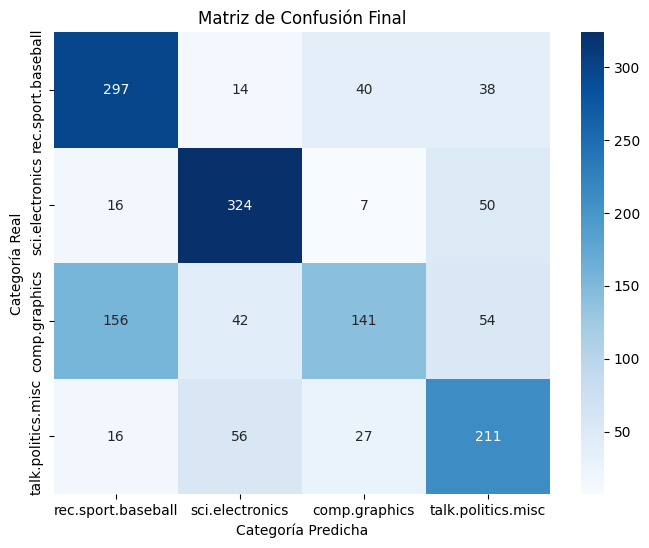

In [13]:
## Predicción + Precisión
y_pred = []
y_true = test_data.target
for doc_corpus in test_corpus:
    doc_topics = lda_model.get_document_topics(doc_corpus, minimum_probability=0.2)
    if doc_topics:
        dominant_topic = max(doc_topics, key=lambda x: x[1])[0]
        y_pred.append(topic_map.get(dominant_topic, -1))
    else:
        y_pred.append(-1)
accuracy = accuracy_score(y_true, y_pred)
print(f"----- Precisión del Modelo -----")
print(f"La precisión (accuracy) del modelo en el conjunto de prueba es: {accuracy:.2%}\n")

## Matriz de Confusión (sin cambios)
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Categoría Predicha')
plt.ylabel('Categoría Real')
plt.title('Matriz de Confusión Final')
plt.show()